<a href="https://colab.research.google.com/github/karans17s/Practical_Implementation_Of_Deep_learning/blob/main/PHASE_5_CIFAR10_TRANSFER_LEARNING_USING_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP : 1 - First Understanding CIFAR-10 dataset





## subset of 80 million tiny images dataset

## 60,000 ( 50,000 for train , 10,000 for test )  with 32 X 32 color img + 10 classes ( 6000 img per class )

### MobileNet , ResNet_18Pretrained deep learning models used for image classification.

### shutil -- copy , move & delete

### mobilenet_v3_large -- version_3 without pretrained wts and mobilenet_v3_large_weights its pretrained wts same for resnet

### ToTensor () -- convert img to pytorch tensor means PIL to pytorch

### Normalize() -- for improve performance ( normalized the img px val ) why use?? prevents vanishing gradient problem and training process stable and efficient

### Resize () -- 244 X 244 for mobilenet and resnet its changes the dimensions of an images to a specific size

### compose () -- for the pipepline ( chains multiple transformations together in seq. )

In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights, resnet18, ResNet18_Weights
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

# STEP : 2 -- Extraction of CIFAR-10

In [ ]:
extract_path = "/content"
train_path = "/content/train.7z"
test_path = "/content/test.7z"

In [ ]:
!pip install py7zr
import py7zr

extract_path = "/content" # or "/content/temp" if you created a temp directory
train_path = "/content/train.7z"
test_path = "/content/test.7z"

# Use py7zr to extract 7z archives
with py7zr.SevenZipFile(train_path, mode='r') as z:
    z.extractall(path=os.path.join(extract_path, "train_data"))

with py7zr.SevenZipFile(test_path, mode='r') as z:
    z.extractall(path=os.path.join(extract_path, "test_data"))

# STEP : 3 create a custom dataset class



## header = 'infer' -- auto detect header row CSV file

## self.labels -- each row represents an img-label pair

## antialias = True means , assume 1024 x 1024 img size after resize = 224 x 224 so this handling and make clear and smooth ( high - resolution images / downscaling )

## getitem -- retrieve img label pair at a specific index scale

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, imgpath, labelpath):
        super().__init__()
        self.imgpath = imgpath
        self.labels = pd.read_csv(labelpath, header='infer')
        self.transform = Compose([
            Resize((224, 224), antialias=True),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return self.labels.shape[0]
    # this return total number of samples in the dataset

    def __getitem__(self, idx):
        img_path = os.path.join(self.imgpath, str(idx + 1) + '.png')
        img = read_image(img_path) / 255.0
        img = self.transform(img)
        label = self.labels.iloc[idx, 1]
        label = name2num[label]
        return img, label

In [ ]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
name2num = {name: idx for idx, name in enumerate(classes)}
num2name = {idx: name for idx, name in enumerate(classes)}

In [ ]:
img_path = os.path.join(extract_path, "train_data/train")
label_path = os.path.join(extract_path, "train_data", "/content/trainLabels.csv")
batch_size = 64
traindataset = TrainDataset(img_path, label_path)
traindataloader = DataLoader(dataset=traindataset, batch_size=batch_size, shuffle=True)

# STEP : 4 -- Create Tranfer Learning Model

## fc layer , change on last layer

## classifier[3] -- modification on 4th layer and replace with a new nn.linear layer and out_features we know that 10.

## base model -- its stores the pre-trained model so we can modify it

In [ ]:
class TransferModel(nn.Module):
    def __init__(self, base_model, out_features):
        super().__init__()
        self.base_model = base_model
        self.base_model.classifier[3] = nn.Linear(self.base_model.classifier[3].in_features, out_features)
    def forward(self, x):
        return self.base_model(x)

# STEP : 5 -- Train the model

## initial loss , correct , total ( img processed ) --- 0

## backward pass -- optimizer.zero_grad() -- clear previous gradient to prevent accumulation

## optimizer.step() -- updates the model's wts



In [ ]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)

        # Forward pass
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * imgs.size(0) # total loss for thr epoch
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    return epoch_loss, epoch_acc


In [ ]:
def train_model(dataloader, model, loss_fn, optimizer, n_epochs):
    losses = []
    accuracies = []

    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        loss, acc = train_one_epoch(dataloader, model, loss_fn, optimizer)
        losses.append(loss)
        accuracies.append(acc)
        print(f"Loss: {loss:.4f}, Accuracy: {acc:.2f}%")

    return losses, accuracies

In [ ]:
mobilenet = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
model_mobilenet = TransferModel(mobilenet, out_features=10).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 47.5MB/s]


In [ ]:
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
optimizer_mobilenet = torch.optim.Adam(model_mobilenet.parameters(), lr=lr)

In [ ]:
n_epochs = 5

In [ ]:
print("Training MobileNet:")
losses_mobilenet, accs_mobilenet = train_model(traindataloader, model_mobilenet, loss_fn, optimizer_mobilenet, n_epochs)

Training MobileNet:
Epoch 1/5
Loss: 0.3879, Accuracy: 86.85%
Epoch 2/5
Loss: 0.2109, Accuracy: 92.92%
Epoch 3/5
Loss: 0.1540, Accuracy: 94.75%
Epoch 4/5
Loss: 0.1298, Accuracy: 95.48%
Epoch 5/5
Loss: 0.1109, Accuracy: 96.20%


# STEP : 6 -- plot training result

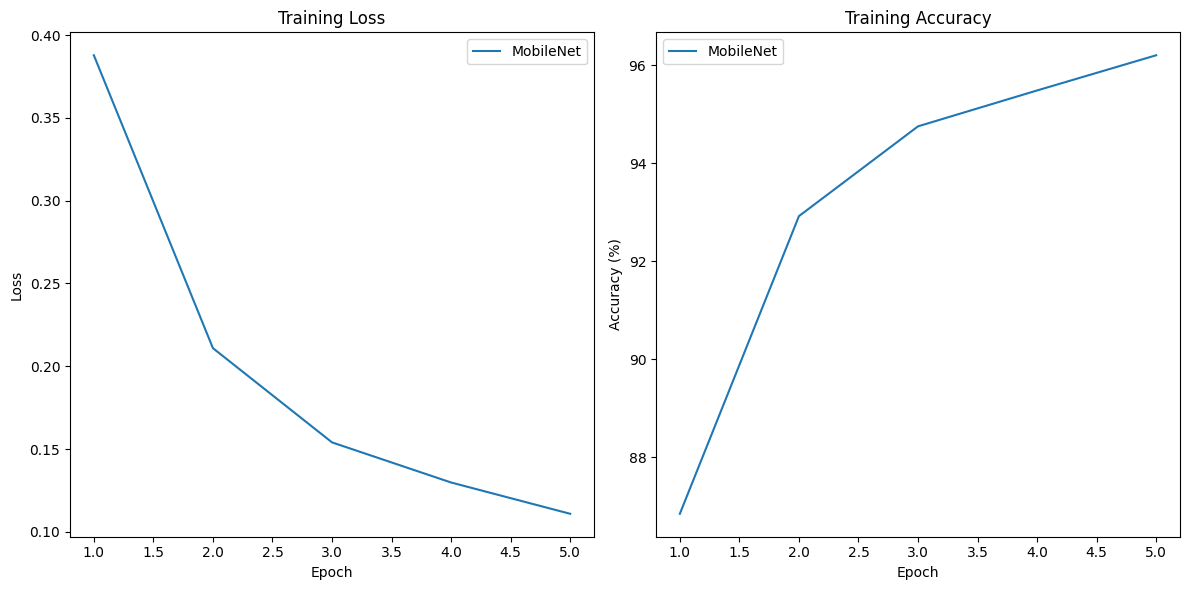

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), losses_mobilenet, label="MobileNet")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), accs_mobilenet, label="MobileNet")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# STEP : 7 testing & evaluation

## getitem -- return 1 img at a time

In [ ]:
class TestDataset(Dataset):
    def __init__(self, imgpath):
        super().__init__()
        self.imgpath=imgpath
        _,_,self.files=next(os.walk(self.imgpath))
        self.length=len(self.files)
        self.transform=Compose([Resize((224,224), antialias=True), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return self.length

    def __getitem__(self,idx):
        finalpath=os.path.join(self.imgpath,str(idx+1))+'.png'
        img=read_image(finalpath)/255.0
        img=self.transform(img)
        return img

testdataset=TestDataset('/content/test_data')
testdataloader=DataLoader(dataset=testdataset, batch_size=batch_size)

In [ ]:
def eval(dataloader, model,loss_fn, path):
    model.eval()
    data=pd.read_csv(path)
    with torch.no_grad():
        for i, imgs in enumerate(dataloader):
            finalbatchpred=np.zeros(imgs.shape[0],dtype='object')
            imgs=imgs.to(device)
            pred=model(imgs)

            pred=torch.argmax(pred,dim=1).type(torch.int).cpu()
            for j,p in enumerate(pred):
                finalbatchpred[j]=num2name[p.item()]
            data.iloc[i*batch_size:i*batch_size+batch_size ,1]=finalbatchpred

    data.to_csv('submission.csv', index=False)
    data.head()

In [ ]:
eval(testdataloader, model_mobilenet, loss_fn, '/content/sampleSubmission.csv')

# NOW , WE USE ANOTHER PRE-TRAINED MODEL RESNET_18

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

In [ ]:
# Load ResNet-18 with pretrained weights
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


In [ ]:
# Modify the fully connected layer to match CIFAR-10 (10 classes)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

In [ ]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = resnet.to(device)

In [ ]:
device

device(type='cuda')

In [ ]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=lr)

In [ ]:
# Training function
def train_model(dataloader, model, loss_fn, optimizer, n_epochs):
    losses, accuracies = [], []
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total * 100
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    return losses, accuracies

In [ ]:
n_epochs = 5
print("Training ResNet-18:")
losses_resnet, accs_resnet = train_model(traindataloader, model_resnet, loss_fn, optimizer_resnet, n_epochs)

Training ResNet-18:
Epoch 1/5
Loss: 0.5531, Accuracy: 81.13%
Epoch 2/5
Loss: 0.3114, Accuracy: 89.31%
Epoch 3/5
Loss: 0.2210, Accuracy: 92.38%
Epoch 4/5
Loss: 0.1605, Accuracy: 94.36%
Epoch 5/5
Loss: 0.1234, Accuracy: 95.78%


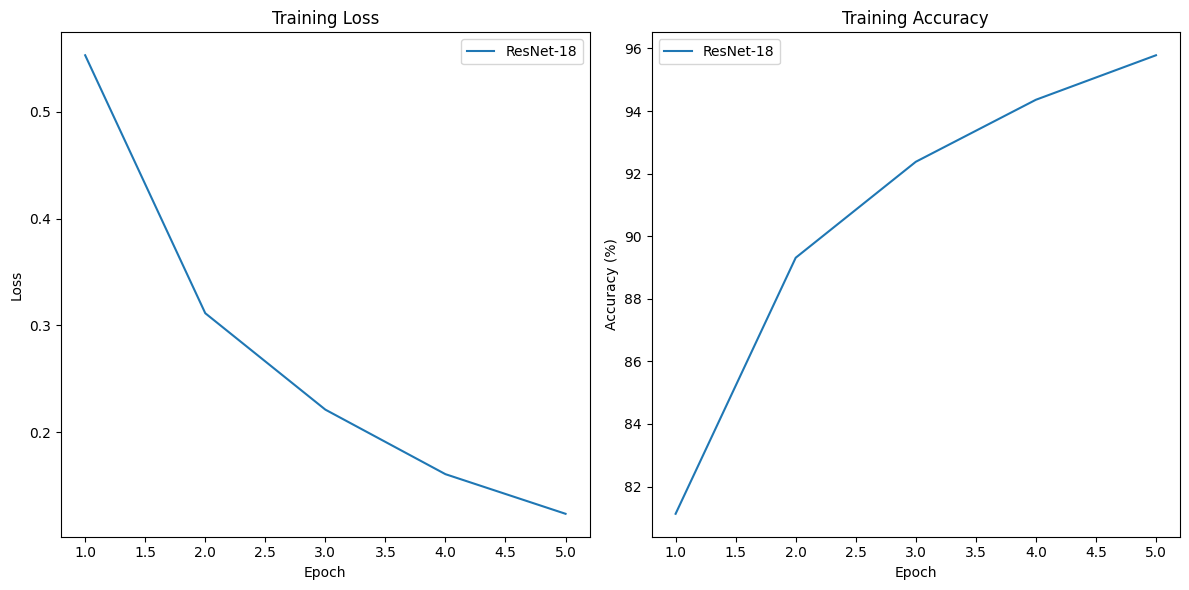

In [ ]:
# Plot Loss and Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), losses_resnet, label="ResNet-18")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), accs_resnet, label="ResNet-18")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
class TestDataset(Dataset):
    def __init__(self, imgpath):
        super().__init__()
        self.imgpath=imgpath
        _,_,self.files=next(os.walk(self.imgpath))
        self.length=len(self.files)
        self.transform=Compose([Resize((224,224), antialias=True), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return self.length

    def __getitem__(self,idx):
        finalpath=os.path.join(self.imgpath,str(idx+1))+'.png'
        img=read_image(finalpath)/255.0
        img=self.transform(img)
        return img

testdataset=TestDataset('/content/test_data')
testdataloader=DataLoader(dataset=testdataset, batch_size=batch_size)

In [ ]:
def eval(dataloader, model,loss_fn, path):
    model.eval()
    data=pd.read_csv(path)
    with torch.no_grad():
        for i, imgs in enumerate(dataloader):
            finalbatchpred=np.zeros(imgs.shape[0],dtype='object')
            imgs=imgs.to(device)
            pred=model(imgs)

            pred=torch.argmax(pred,dim=1).type(torch.int).cpu()
            for j,p in enumerate(pred):
                finalbatchpred[j]=num2name[p.item()]
            data.iloc[i*batch_size:i*batch_size+batch_size ,1]=finalbatchpred

    data.to_csv('submission.csv', index=False)
    data.head()

In [ ]:
eval(testdataloader, model_mobilenet, loss_fn, '/content/sampleSubmission.csv')

# Some Comp. of Pre-trained models

## 1) MobileNet here , i used v3 ( version-3 model )

###MobileNetV1 --for small model / depthwise separable convo.

###MobilenetV2 -- faster / better acc.

###MobileNetV3 -- for mobile / IOT

## so , mob_net_v3 ( large ) -- 21 convo layer + 11 inverted residual blocks + 1 FC  if small then 16 convo + 7 inverted residual block ( narrow -> wide -> narrow ) and residual block ( wide --> narrow --> wide )

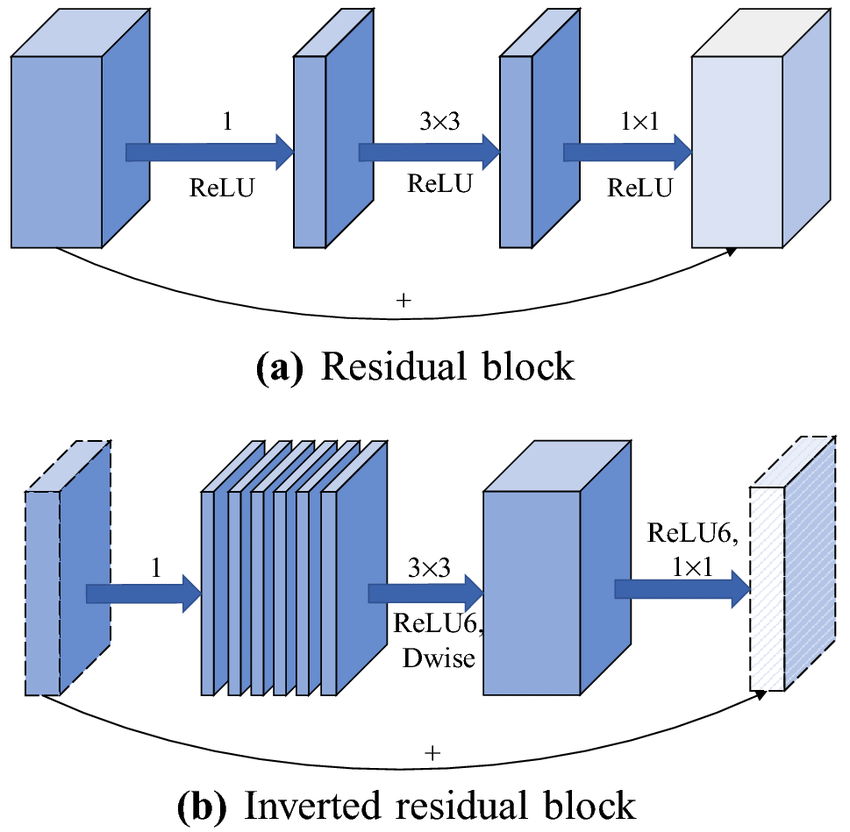


## 1280 neurons in large v3 mob_net model and 5.4 m parameter

## 2) ResNet ( Residual Network )

## i used resnet-18 model , total 18 layer with 17 convo layer + 1 fc layer last ( here residual block its prevent vanishing gradients prob. ) 11.7 m parameter

## other resnet version like 34,50,101,152...


## other architectures:
a) VGG
b) efficientNet
c) DenseNet
d) GoogLeNet

